In [49]:
import sys
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn
import scipy
from scipy.spatial.distance import pdist

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import mdtraj as md

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import distance_metric

from sklearn_extra.cluster import KMedoids

In [2]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../..")
sys.path.insert(1, "/project2/roux/scguo/KDML/")
import util
import plotting
import kdml

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots

In [4]:
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load toy data

In [5]:
double_well_data = np.load("/project2/roux/scguo/toy_models/double_well.npy")
print(double_well_data.shape)

(200000000, 3)


In [6]:
data = np.split(double_well_data[::1000, 1:], 100)

In [7]:
data[0].shape

(2000, 2)

# Convert to triplets

In [8]:
from functools import lru_cache

In [9]:
from logging import debug

In [10]:
def triplets(trajs, close=1, stride=1, far=None):
    """Get three trajectories which represent triplets of close/far pairs

    Trajectories A, B, C constructued such that frame A[i] is close to frame
    B[i] and far from frame C[i].

    Paramters
    ---------
    trajs : list of ndarray of float, (n_frames, n_features)
    close : int
        number of frames between A[i] and B[i] -- to be considered "close"
    stride : int
        Frequency to get from the dataset
    far : {int, None}
        If `far` is none, the point `C` is sampled randomly from the dataset.
        If `far` is an int, the point `C` is taken to be `far` frames after
        point A

    Returns
    -------
    A : ndarray of float (n_total_frames, n_features)
    B : ndarray of float (n_total_frames, n_features)
    C : ndarray of float (n_total_frames, n_features)
    """

    cumsum = np.cumsum([len(traj) for traj in trajs])

    def split(longindex):
        traj = np.where(longindex <= cumsum)[0][0]
        if traj == 0:
            frame = longindex
        else:
            frame = longindex - cumsum[traj - 1]
        return traj, frame

    # # load the trajs with caching of the two most recently loaded trajectories?
    # @lru_cache(maxsize=2)
    # def load_traj(traj_index):
    #     return trajs[traj_index]

    a_indices = np.arange(0, cumsum[-1], stride)
    b_indices = a_indices + close
    if far is not None:
        c_indices = a_indices + far
    else:
        c_indices = np.random.permutation(len(a_indices))
        np.sort(c_indices)

    ind_to_keep = np.where(c_indices < cumsum[-1])
    c_indices = c_indices[ind_to_keep]
    b_indices = b_indices[ind_to_keep]
    a_indices = a_indices[ind_to_keep]

    a_frames, b_frames, c_frames = [], [], []
    for i, a in enumerate(a_indices):
        b, c = b_indices[i], c_indices[i]
        itraj_a, iframe_a = split(a)
        itraj_b, iframe_b = split(b)
        itraj_c, iframe_c = split(c)

        # print 't', itraj_a, itraj_b, itraj_c
        debug(f"f {iframe_a} {iframe_b} {iframe_c}")

        if a < b < c < cumsum[-1] and far is not None and itraj_a == itraj_b == itraj_c:
            traj = trajs[split(a)[0]]
            if iframe_a < len(traj) and iframe_b < len(traj) and iframe_c < len(traj):
                frame_a = traj[iframe_a]
                frame_b = traj[iframe_b]
                frame_c = traj[iframe_c]

                a_frames.append(frame_a)
                b_frames.append(frame_b)
                c_frames.append(frame_c)

        elif a < b < c < cumsum[-1] and far is None and itraj_a == itraj_b:
            traj_a, traj_b, traj_c = trajs[itraj_a], trajs[itraj_b], trajs[itraj_c]
            if (
                iframe_a < len(traj_a)
                and iframe_b < len(traj_b)
                and iframe_c < len(traj_c)
            ):

                a_frames.append(traj_a[iframe_a])
                b_frames.append(traj_b[iframe_b])
                c_frames.append(traj_c[iframe_c])

    A = np.array(a_frames)
    B = np.array(b_frames)
    C = np.array(c_frames)

    if far is None:
        # if far is none, what we really want is to have randomly selected
        # shuffled frames
        np.random.shuffle(C)

    return A, B, C

In [11]:
# %prun A, B, C = triplets(data, close=1, far=10)

In [12]:
A, B, C = triplets(data, close=1, far=10)

In [13]:
alpha = np.arange(0.1, 1.1, 0.1)

In [14]:
# all_rho, all_weights = [], []
# for a in alpha:
#     rho, weights = kdml.lmmdm.optimize_diagonal(A - B, B - C, a)
#     all_rho.append(rho)
#     all_weights.append(weights)

In [15]:
# np.save("../data/kdml_diag_doublewell", all_weights[4])
weights = np.load("../data/kdml_diag_doublewell.npy")

In [16]:
data_arr = np.concatenate(data)
data_arr.shape

(200000, 2)

In [17]:
# pdists = pdist(data_arr[::100], 'seuclidean', V=weights)

In [18]:
# pdists.shape

In [19]:
# k = 100

# # Initialize initial medoids using K-Means++ algorithm
# initial_medoids = kmeans_plusplus_initializer(data_arr, k).initialize(return_index=True)

# # Create instance of K-Medoids (PAM) algorithm.
# kmedoids_instance = kmedoids(pdists, initial_medoids, data_type="distance_matrix")

# # Run cluster analysis and obtain results.
# kmedoids_instance.process()
# clusters = kmedoids_instance.get_clusters()
# medoids = kmedoids_instance.get_medoids()

In [20]:
def seuclidean_metric(V):
    """ """

    def metric(a, b):
        return np.dot(a, V * b)

    return metric

In [21]:
# try hierarchical clustering
se_metric = seuclidean_metric(weights)

In [22]:
se_metric(data_arr[0], data_arr[1])

0.9300471568653714

In [35]:
import importlib

In [39]:
import sklearn_extra

In [44]:
importlib.reload(sklearn_extra)

ModuleNotFoundError: spec not found for the module 'sklearn_extra'

In [23]:
k = 10
km = KMedoids(
    n_clusters=k, metric=se_metric, method="pam", init="k-medoids++", max_iter=0
).fit(data_arr[::100])
medoids = km.medoid_indices_

k-medoids++


In [24]:
medoids

array([  75, 1787,  959, 1405, 1485, 1395, 1045,  642,  731,  724])

In [30]:
km.medoid_indices_ = np.random.randint(len(data_arr), size=10)

In [31]:
km.medoid_indices_

array([ 35556,  85021,  98691,  25576, 159701, 115838,  80022,  93756,
       104338,  28733])

In [25]:
km2 = KMedoids(n_clusters=k, metric=se_metric, method="pam", init=medoids, max_iter=1)

In [33]:
km2.medoid_indices_ = np.random.randint(len(data_arr), size=10)

In [27]:
km2.fit(data_arr[::100])

[  75 1787  959 1405 1485 1395 1045  642  731  724]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (self.init not in init_methods) and (not hasattr(self.init, "__array__")):
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "random":  # Random initialization
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.init == "k-medoids++":
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  el

KMedoids(init=array([  75,  332,  959, 1405, 1485, 1395, 1045,  642,  731,  724]),
         max_iter=1, method='pam',
         metric=<function seuclidean_metric.<locals>.metric at 0x7f5dc046c290>,
         n_clusters=10)

In [35]:
km2.fit(data_arr[::100])

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:247: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


KMedoids(init='random', max_iter=1, method='pam',
         metric=<function seuclidean_metric.<locals>.metric at 0x7efcc696fb90>,
         n_clusters=10)

In [28]:
km2.medoid_indices_

array([  75,  332,  959, 1405, 1485, 1395, 1045,  642,  731,  724])

In [45]:
def mini_batch_kmedoids(data, k, batchsize=0.02, metric=None, n_iter=100, **kwargs):
    N = len(data)

    for i in range(n_iter + 1):
        # randomly sample batchsize
        n_batch = int(batchsize * len(data))
        inds = np.random.choice(range(len(data)), n_batch, replace=True)
        batch_data = data[inds]

        if i == 0:
            # Initialize initial medoids using k-means++ algorithm
            print("Initializing medoids...")
            km = KMedoids(
                n_clusters=k,
                metric=metric,
                method="pam",
                init="k-medoids++",
                max_iter=0,
            ).fit(batch_data)
            medoids = km.medoid_indices_
            print("Finished initialization.")

        else:
            print(f"Iteration {i}...")
            # initialize with previous medoids
            km = KMedoids(
                n_clusters=k, metric=metric, method="pam", init=medoids, max_iter=1
            )

            # Perform one PAM step and get updated medoids
            km.fit(batch_data)
            medoids = km.medoid_indices_

    return km

In [30]:
np.random.seed(123)

In [21]:
# km = mini_batch_kmedoids(data_arr, 10, batchsize=0.0002, metric="seuclidean", V=weights, n_iter=10)

In [31]:
k = 100
batchsize = 0.1

In [32]:
# medoids = kmeans_plusplus_initializer(batch_data, k).initialize(return_index=True)

In [33]:
# medoids

In [34]:
# # medoids = kmeans_plusplus_initializer(batch_data, k).initialize(return_index=True)
# N = len(data)
# medoids = np.random.choice(range(N), size=k, replace=False)

In [38]:
from scipy.spatial.distance import squareform

In [39]:
n_batch = int(batchsize * len(data_arr))
inds = np.random.choice(range(len(data_arr)), n_batch, replace=False)
batch_data = data_arr[inds]
pdists = squareform(pdist(batch_data, metric="seuclidean", V=weights))

In [40]:
max(medoids)

99

In [41]:
pdists.shape

(20000, 20000)

In [42]:
from pyclustering.utils import metric

In [43]:
met = metric.distance_metric(
    metric.type_metric.USER_DEFINED, func=se_metric, numpy_usage=True
)

In [44]:
kmedoids_instance = kmedoids(
    batch_data, medoids, data_type="points", itermax=1, metric=met
)

In [45]:
kmedoids_instance.process()

KeyboardInterrupt: 

In [18]:
from scipy.cluster import hierarchy

In [19]:
from sklearn.cluster import AgglomerativeClustering, OPTICS

In [20]:
from scipy.spatial import distance

In [21]:
ac = OPTICS(metric="seuclidean", metric_params={"V": weights}, n_jobs=-1)

In [ ]:
ac.fit(data_arr)

In [ ]:
import dill as pickle

In [ ]:
with open("../../data/optics_test.dat.pkl", mode="wb+") as f:
    pickle.dump(f, ac)

In [50]:
print(mini_batch_kmedoids)

<function mini_batch_kmedoids at 0x7f5d9b526b90>


In [56]:
def mini_batch_kmedoids(data, k, batchsize=0.02, metric=None, n_iter=100, **kwargs):
    N = len(data)

    for i in range(n_iter + 1):
        # randomly sample batchsize
        n_batch = int(batchsize * len(data))
        inds = np.random.choice(range(len(data)), n_batch, replace=True)
        batch_data = data[inds]

        if i == 0:
            # Initialize initial medoids using k-means++ algorithm
            print("Initializing medoids...")
            km = KMedoids(
                n_clusters=k,
                metric=metric,
                method="pam",
                init="k-medoids++",
                max_iter=0,
            ).fit(batch_data)
            medoids = inds[km.medoid_indices_]
            print("Finished initialization.")

        else:
            print(f"Iteration {i}...")
            # initialize with previous medoids
            km = KMedoids(
                n_clusters=k, metric=metric, method="pam", init=medoids, max_iter=1
            )

            # Perform one PAM step and get updated medoids
            km.fit(batch_data)
            # indices in original data
            medoids = inds[km.medoid_indices_]

    return km

In [57]:
labels = km.predict(data_arr)

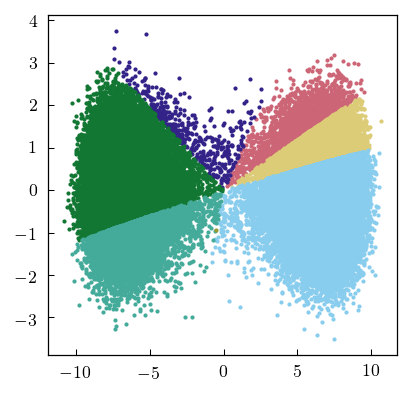

In [58]:
fig, ax = plt.subplots()
for k in range(10):
    # Find indices of data in cluster k
    idx = np.where(labels == k)[0]
    ax.scatter(data_arr[idx, 0], data_arr[idx, 1], marker=".")

In [73]:
k = 20
km = mini_batch_kmedoids(data_arr, k, batchsize=0.01, metric=se_metric, n_iter=20)

Initializing medoids...
k-medoids++
Finished initialization.
Iteration 1...
[1533 1239  657  162  698  315 1346 1946  782 1027 1974 1325 1086  208
 1737 1145 1583  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/proj

Iteration 2...
[1533 1239  657  849  698  315 1346 1946  782 1027 1974 1325 1086  208
 1737 1145 1583  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 3...
[1533 1239  657  849  698  315 1346 1946  782 1027 1974 1642 1086  208
 1737 1145 1583  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 4...
[1533 1239  657  849  698  833 1346 1946  782 1027 1974 1642 1086  208
 1737 1145 1583  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 5...
[1533 1239  657  903  698  833 1346 1946  782 1027 1974 1642 1086  208
 1737 1145 1583  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 6...
[1533 1239  657  903  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1583  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 7...
[1533 1239  657  138  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1583  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 8...
[1533 1239  657  138  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645  838 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 9...
[1533 1239  657  138  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 10...
[1533  667  657  138  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 11...
[ 239  667  657  138  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 12...
[ 239  207  657  138  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529 1586 1545]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 13...
[ 239  207  657  138  698  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529 1586 1564]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 14...
[ 239  207  657  138  972  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529 1586 1564]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 15...
[ 239  207  657  138  660  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529 1586 1564]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 16...
[ 239  207  657  138  660  833 1346 1946  782 1027 1974 1642 1086  391
 1737 1145 1645 1529   16 1564]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 17...
[ 239  207  657  138  660  833 1346 1946  151 1027 1974 1642 1086  391
 1737 1145 1645 1529   16 1564]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 18...
[ 239  207  657  138  660  833 1346 1946  151 1027 1974 1642 1086  391
 1737 1145 1645 1529   16  513]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 19...
[ 239  207  657  138  660  833 1346 1946  151 1027 1974 1642 1086  391
 1792 1145 1645 1529   16  513]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 20...
[ 239  207  657  138  660 1372 1346 1946  151 1027 1974 1642 1086  391
 1792 1145 1645 1529   16  513]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

In [76]:
weights ** (-1)

array([13.84809195,  1.07783257])

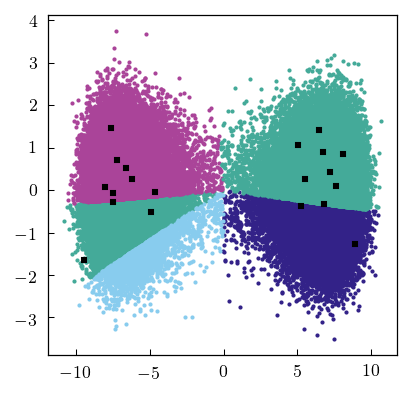

In [74]:
labels = km.predict(data_arr)
fig, ax = plt.subplots()
for i in range(k):
    # Find indices of data in cluster k
    idx = np.where(labels == i)[0]
    ax.scatter(data_arr[idx, 0], data_arr[idx, 1], marker=".")
    ax.plot(*km.cluster_centers_[i], "sk")

In [67]:
labels

array([857, 952,  41, 643, 722, 247, 928, 357, 455, 203, 589, 250, 794,
       918, 724, 800, 149, 134, 242, 456])

In [68]:
# normal euclidean metric
k = 20
km = mini_batch_kmedoids(data_arr, k, batchsize=0.01, metric="euclidean", n_iter=20)

Initializing medoids...
k-medoids++
Finished initialization.
Iteration 1...
[ 228  468  847 1403 1185  873 1477 1652  899 1867 1112 1670  397  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/proj

Iteration 2...
[ 228  468  847 1403 1185  873 1477 1652  899 1867 1176 1670  397  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 3...
[ 228  468  847 1403 1185  873 1477 1652  899 1867 1176 1660  397  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 4...
[ 228  468  847 1403 1185  873 1477 1652  899 1867 1176  648  397  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 5...
[ 228  468  847 1403 1185  873 1477 1652  495 1867 1176  648  397  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 6...
[ 228  468  847 1403 1185  873 1477 1652  495 1867 1678  648  397  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 7...
[ 228 1960  847 1403 1185  873 1477 1652  495 1867 1678  648  397  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 8...
[ 228 1960  847 1403 1185  873 1477 1652  495 1867 1678  648 1853  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 9...
[ 228 1960  847 1403 1185  873 1477  403  495 1867 1678  648 1853  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 10...
[ 228 1960 1596 1403 1185  873 1477  403  495 1867 1678  648 1853  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 11...
[ 228 1960 1596 1403 1391  873 1477  403  495 1867 1678  648 1853  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 12...
[ 228 1960 1596 1403 1391  873 1477  403  495 1867 1678  851 1853  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 13...
[ 228 1960 1596 1403 1391  873 1477  403 1771 1867 1678  851 1853  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 14...
[ 228 1960 1596 1319 1391  873 1477  403 1771 1867 1678  851 1853  575
 1686 1661 1550  828 1614 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 15...
[ 228 1960 1596 1319 1391  873 1477  403 1771 1867 1678  851 1853  575
 1686 1661 1550  828 1443 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 16...
[ 228 1960 1596 1319 1391 1263 1477  403 1771 1867 1678  851 1853  575
 1686 1661 1550  828 1443 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 17...
[ 228 1960 1596 1319 1391 1263 1477  403 1771 1867 1678  851  449  575
 1686 1661 1550  828 1443 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 18...
[ 228 1960 1596 1319 1391 1263 1477  403 1771 1867 1678  851  449  845
 1686 1661 1550  828 1443 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 19...
[ 228 1960 1596 1319 1777 1263 1477  403 1771 1867 1678  851  449  845
 1686 1661 1550  828 1443 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/clust

Iteration 20...
[ 228 1960 1596 1319 1777 1263 1477  403 1771 1867 1678  851  449  845
 1686 1661  493  828 1443 1544]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:282: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  )


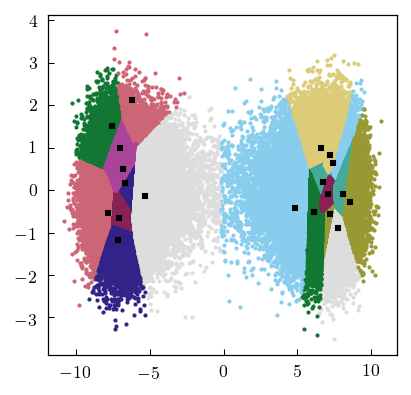

In [72]:
labels = km.predict(data_arr)
fig, ax = plt.subplots()
for k in range(20):
    # Find indices of data in cluster k
    idx = np.where(labels == k)[0]
    ax.scatter(data_arr[idx, 0], data_arr[idx, 1], marker=".")
    ax.plot(*km.cluster_centers_[k], "sk")

In [71]:
print(labels)

[19 18  0 ... 11  8 18]


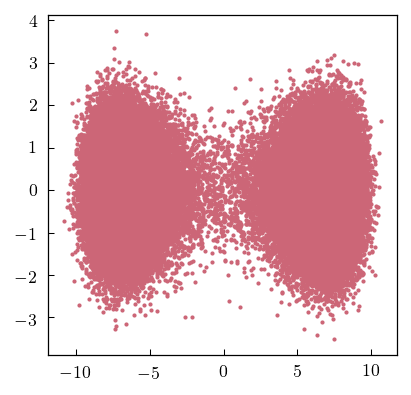

In [70]:
plt.scatter(*data_arr.T, marker=".")

In [80]:
# inverse weights
inv_weights = (1 / weights) / (np.sum(1 / weights))
se_inv = seuclidean_metric(inv_weights)

In [81]:
k = 20
km = mini_batch_kmedoids(data_arr, k, batchsize=0.01, metric=se_inv, n_iter=20)

Initializing medoids...
k-medoids++
Finished initialization.
Iteration 1...
[ 710  208 1729 1584  673  221 1970 1092 1082 1174 1724  734    6 1574
 1355 1926  703 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raise ValueError(
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/proj

Iteration 2...
[ 710  208 1729 1584  673  221 1748 1092 1082 1174 1724  734    6 1574
 1355 1926  703 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 3...
[ 710  208 1729 1584  673  221 1748 1092 1082 1174 1724  734    6 1574
  175 1926  703 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 4...
[ 710  208 1729 1584 1523  221 1748 1092 1082 1174 1724  734    6 1574
  175 1926  703 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 5...
[ 710  208 1729 1584 1523  221 1748 1092 1082 1174 1724  734    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 6...
[ 293  208 1729 1584 1523  221 1748 1092 1082 1174 1724  734    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 7...
[ 293  208  593 1584 1523  221 1748 1092 1082 1174 1724  734    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 8...
[ 293  208  593 1584 1523  221 1748 1092  571 1174 1724  734    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 9...
[ 293  208  593 1584 1523  221 1748 1092  571 1174   68  734    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 10...
[ 293  208  593 1584 1523  221 1748 1092  571 1174   68 1036    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 11...
[ 293  208  593 1584 1636  221 1748 1092  571 1174   68 1036    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 12...
[ 293  208  593 1584 1636 1132 1748 1092  571 1174   68 1036    6 1574
  175 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 13...
[ 293  208  593 1584 1636 1132 1748 1092  571 1174   68 1036    6 1574
 1367 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 14...
[ 293  208  593 1584 1636  550 1748 1092  571 1174   68 1036    6 1574
 1367 1926  649 1249  990 1023]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 15...
[ 293  208  593 1584 1636  550 1748 1092  571 1174   68 1036    6 1574
 1367 1926  649 1249  990    8]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 16...
[ 293  416  593 1584 1636  550 1748 1092  571 1174   68 1036    6 1574
 1367 1926  649 1249  990    8]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 17...
[ 293  416  593 1584 1636  550 1748 1092  571 1174   68 1196    6 1574
 1367 1926  649 1249  990    8]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 18...
[ 293  416  593 1584 1636  550 1748 1092  571 1174   68 1196    6 1574
 1367 1955  649 1249  990    8]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 19...
[ 293  416  593 1584 1636  550 1748 1092  571 1174   68  878    6 1574
 1367 1955  649 1249  990    8]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

Iteration 20...
[ 293  416  593 1584 1636  550 1748 1092  571 1174   68  878  194 1574
 1367 1955  649 1249  990    8]


/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self.init
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = random_state_.choice(len(D), n_clusters, replace=False)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:419: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  medoids = self._kpp_init(D, n_clusters, random_state_)
/project2/roux/scguo/scikit-learn-extra/sklearn_extra/cluster/_k_medoids.py:425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ]
/project2/roux/scguo/

In [83]:
km.cluster_centers_

array([[  9.02105962,  -0.88889561],
       [  6.2232412 ,  -0.78852579],
       [-10.06027823,   0.36106786],
       [ -7.25957234,   0.53621975],
       [  5.84982554,  -0.12137595],
       [ -3.82914432,   0.1724554 ],
       [  3.58538093,  -0.53542803],
       [ -8.1849225 ,   0.47768884],
       [  4.94942846,  -1.08496552],
       [  6.34722581,  -0.47980252],
       [  7.64738178,   0.51746891],
       [ -6.68302204,  -0.375094  ],
       [  5.5506058 ,   0.10841967],
       [  6.1415507 ,   0.86381487],
       [  7.6321392 ,  -0.76899751],
       [ -5.42269791,   0.50286457],
       [  2.87218396,  -0.12162698],
       [ -8.73594208,   0.7196765 ],
       [  6.12628052,   0.57490104],
       [ -5.7810481 ,   0.2709631 ]])

In [84]:
km.medoid_indices_

array([ 293,  416,  813, 1584, 1636,  550, 1748, 1092,  571, 1174,   68,
        878,  194, 1574, 1367, 1955,  649, 1249,  990,    8])

In [ ]:
labels = np.min(scipy.spatial.distance.cdist(data_arr, km.cluster_centers_))

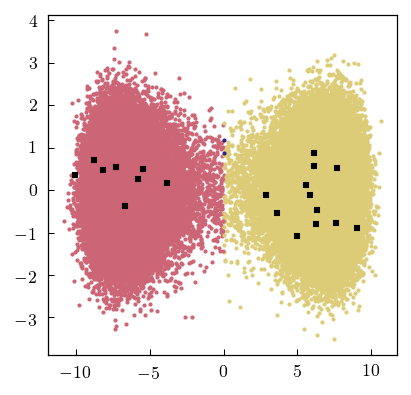

In [82]:
labels = 
fig, ax = plt.subplots()
for i in range(k):
    # Find indices of data in cluster k
    idx = np.where(labels == i)[0]
    ax.scatter(data_arr[idx,0], data_arr[idx,1], marker='.')
    ax.plot(*km.cluster_centers_[i], 'sk')